# ML for wage prediction

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
rdata_read = pyreadr.read_r("../data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'data' ]

data.shape

(5150, 20)

The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [3]:
Z = data.loc[:, 'sex':'ind2']
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

In [4]:
bins_hist = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300 , 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540]

(0.0, 3000.0)

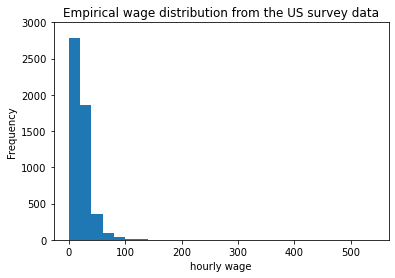

In [5]:
plt.hist(data.wage , bins = np.arange(0, 550, 20) )
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title( 'Empirical wage distribution from the US survey data' )
plt.ylim((0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:
 
1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [6]:
nrow = data.shape[0]
length = int(nrow*(3/4))
data = data.reset_index().drop( 'rownames', axis = 1)

In [7]:
from numpy.random import default_rng


random.seed(30)
rng = default_rng()
training = rng.choice(nrow, size = length, replace=False)
training_bool = data.index.isin( training )

data_train = data.iloc[training,:]
data_test = data[~training_bool]

In [8]:
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
4646,13.942308,2.634928,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.6400,0.512000,0.409600,7340,20,7380,14
5059,31.250000,3.442019,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,22.5,5.0625,11.390625,25.628906,630,2,1680,5
3085,26.442308,3.274965,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0400,0.008000,0.001600,800,2,2180,5
2628,24.038462,3.179655,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,0.8100,0.729000,0.656100,9620,22,4880,9
4293,40.865385,3.710283,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,12.0,1.4400,1.728000,2.073600,430,1,7860,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,9.615385,2.263364,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.2500,0.125000,0.062500,3645,11,7970,18
2531,31.250000,3.442019,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,25.0,6.2500,15.625000,39.062500,3255,10,8190,18
1151,22.500000,3.113515,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,28.0,7.8400,21.952000,61.465600,860,2,6990,12
1592,36.538462,3.598365,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,19.0,3.6100,6.859000,13.032100,430,1,9490,22


In [9]:
data_train.shape

(3862, 20)

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [11]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')
y_basic_test, model_X_basic_test = patsy.dmatrices(formula_basic, data_test, return_type='dataframe')
p_basic = model_X_basic_train.shape[ 1 ]

y_flex_train, model_X_flex_train = patsy.dmatrices(formula_flex, data_train, return_type='dataframe')
y_flex_test, model_X_flex_test = patsy.dmatrices(formula_flex, data_test, return_type='dataframe')
p_flex = model_X_flex_train.shape[ 1 ]

In [12]:
model_X_basic_train

,Intercept,occ2[T.10],occ2[T.11],occ2[T.12],occ2[T.13],occ2[T.14],occ2[T.15],occ2[T.16],occ2[T.17],occ2[T.18],...,sex,exp1,exp2,shs,hsg,scl,clg,mw,so,we
4646,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.6400,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5059,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,22.5,5.0625,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0400,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2628,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.8100,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4293,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,1.4400,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2531,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,25.0,6.2500,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1151,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,28.0,7.8400,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1592,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.0,3.6100,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
Y_train = data_train['lwage']
Y_test = data_test['lwage']


In [14]:
print(p_basic)
print(p_flex)

52
246


As known from our first lab, the basic model consists of $10$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression. 

### OLS

We fit the basic model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [15]:
# ols (basic model)
lm_basic = sm.OLS( Y_train, model_X_basic_train )
fit_lm_basic = lm_basic.fit()

# Compute the Out-Of-Sample Performance
yhat_lm_basic = fit_lm_basic.predict( model_X_basic_test )
print( f"The mean squared error (MSE) using the basic model is equal to , {np.mean((Y_test-yhat_lm_basic)**2)} ") # MSE OLS (basic model)    

The mean squared error (MSE) using the basic model is equal to , 0.24484293883842734 


To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [16]:
resid_basic = (Y_test-yhat_lm_basic)**2

MSE_lm_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_basic

Coef.       0.244843
Std.Err.    0.016479
Name: const, dtype: float64

We also compute the out-of-sample $R^2$:

In [17]:
R2_lm_basic = 1 - ( MSE_lm_basic[0]/Y_test.var() )
print( f"The R^2 using the basic model is equal to, {R2_lm_basic}" ) # MSE OLS (basic model) 

The R^2 using the basic model is equal to, 0.26215755532494966


We repeat the same procedure for the flexible model.

In [18]:
# ols (flex model)
lm_flex = sm.OLS( Y_train, model_X_flex_train )
fit_lm_flex = lm_flex.fit()

yhat_lm_flex = fit_lm_flex.predict( model_X_flex_test )

resid_flex = (Y_test-yhat_lm_flex)**2

MSE_lm_flex = sm.OLS( resid_flex , np.ones( resid_flex.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_flex

R2_lm_flex = 1 - ( MSE_lm_flex[0]/Y_test.var() )
print( f"The R^2 using the flex model is equal to, {R2_lm_flex}" ) # MSE OLS (flex model) 

The R^2 using the flex model is equal to, 0.1716603283158754


We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


Considering the basic model, we run a lasso/post-lasso regression first and then we compute the measures for the out-of-sample performance. Note that applying the package *hdm* and the function *rlasso* we rely on a theoretical based choice of the penalty level $\lambda$ in the lasso regression.

In [19]:
import hdmpy

In [20]:
fit_rlasso = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

#### Estimating the predictions from rlasso models
We have to know that the residuals output come from this formula:

- x1 = x - np.ones( (x.shape[1] , 1) ) @ x.mean( axis = 0 )
- beta = model.est['beta'].loc[ fit_rlasso.est['index'].iloc[:, 0].to_list(), ].to_numpy()
- y1 = y - y.mean()
- yhat = x1 @ beta + y.mean()

So we have to apply those transfomations to original test data


In [21]:
# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso = new_x1[ :, fit_rlasso.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso = fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso = (x1_est_rlasso @ beta_rlasso) + np.mean( Y_test.to_numpy() )
residuals_rlasso = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso

In [22]:
# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post = new_x1[ :, fit_rlasso_post.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post = fit_rlasso_post.est['beta'].loc[ fit_rlasso_post.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post = (x1_est_rlasso_post @ beta_rlasso_post) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post

In [23]:
MSE_lasso = sm.OLS( ( residuals_rlasso )**2 , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ( residuals_rlasso_post )**2  , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

R2_lasso = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post = 1 - MSE_lasso_post.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso},for lasso and {R2_lasso_post} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.24603119827446907,for lasso and 0.24603119827446907 for post-lasso


Now, we repeat the same procedure for the flexible model.

In [24]:
fit_rlasso_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

In [25]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_flex = new_x1[ :, fit_rlasso_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_flex = fit_rlasso_flex.est['beta'].loc[ fit_rlasso_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_flex = (x1_est_rlasso_flex @ beta_rlasso_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_flex

In [26]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post_flex = new_x1[ :, fit_rlasso_post_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post_flex = fit_rlasso_post_flex.est['beta'].loc[ fit_rlasso_post_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post_flex = (x1_est_rlasso_post_flex @ beta_rlasso_post_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post_flex

In [27]:
MSE_lasso_flex = sm.OLS( ( residuals_rlasso_flex )**2 , np.ones( yhat_rlasso_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post_flex = sm.OLS( ( residuals_rlasso_post_flex )**2  , np.ones( yhat_rlasso_post_flex.size )  ).fit().summary2().tables[1].round(3)

R2_lasso_flex = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post_flex = 1 - MSE_lasso_post_flex.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso_flex},for lasso and {R2_lasso_post_flex} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.24603119827446907,for lasso and 0.2369835726537627 for post-lasso


It is worth to notice that lasso regression works better for the more complex model.

In contrast to a theoretical based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [28]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
import statsmodels.api as sm

In [29]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape( Y_train.to_numpy().size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv_basic = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_basic_train, std_Y )
fit_ridge_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_basic_train , std_Y )
fit_elnet_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_basic_train , std_Y )

# Predictions
yhat_lasso_cv_basic = scaler.inverse_transform( fit_lasso_cv_basic.predict( model_X_basic_test ).reshape(-1,1) )
yhat_ridge_basic = scaler.inverse_transform( fit_ridge_basic.predict( model_X_basic_test ).reshape(-1,1) )
yhat_elnet_basic = scaler.inverse_transform( fit_elnet_basic.predict( model_X_basic_test ).reshape(-1,1) )

In [30]:
MSE_lasso_cv_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_basic)**2 ) , np.ones( yhat_lasso_cv_basic.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_basic)**2 ) , np.ones( yhat_ridge_basic.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_basic)**2 ) , np.ones( yhat_elnet_basic.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [31]:
R2_lasso_cv_basic = 1- MSE_ridge_basic.iloc[0,0] / np.var( Y_test )
R2_ridge_basic = 1- MSE_lasso_cv_basic.iloc[0,0] / np.var( Y_test )
R2_elnet_basic = 1- MSE_elnet_basic.iloc[0,0] / np.var( Y_test )

In [32]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_basic},{R2_ridge_basic},{R2_elnet_basic}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.004761181722299113,0.26111057430897966,0.2641264495158818


In [33]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape( Y_train.to_numpy().size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv_flex = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_flex_train, std_Y )
fit_ridge_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_flex_train , std_Y )
fit_elnet_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_flex_train , std_Y )

# Predictions
yhat_lasso_cv_flex = scaler.inverse_transform( fit_lasso_cv_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_ridge_flex = scaler.inverse_transform( fit_ridge_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_elnet_flex = scaler.inverse_transform( fit_elnet_flex.predict( model_X_flex_test ).reshape(-1,1) )

In [34]:
MSE_lasso_cv_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_flex)**2 ) , np.ones( yhat_lasso_cv_flex.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_flex)**2 ) , np.ones( yhat_ridge_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_flex)**2 ) , np.ones( yhat_elnet_flex.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [35]:
R2_lasso_cv_flex = 1- MSE_ridge_flex.iloc[0,0] / np.var( Y_test )
R2_ridge_flex = 1- MSE_lasso_cv_flex.iloc[0,0] / np.var( Y_test )
R2_elnet_flex = 1- MSE_elnet_flex.iloc[0,0] / np.var( Y_test )

In [36]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_flex},{R2_ridge_flex},{R2_elnet_flex}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.010792932136103328,0.2580946991020775,0.2520629486882733


The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are applying regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. First, we load the relevant libraries

and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from scipy.sparse import diags
from IPython.display import Image, display

**cp** = It is the amout by which splitting that node would decarease the relative error.\
It has the same meaning as min_impurity_decrease 
Apparently, Sklearn does not have tree prune function as stated in theis user guide. I take the info from [this link](https://stats.stackexchange.com/questions/152553/what-is-the-equivalent-of-the-complexity-parameter-rpart-in-r-in-python-for)

we can Preprune and postprune decission trees.

Preprunning is stopping the growth of decision tree on an early stage. we can limit paramters like max_depth, min_samples. We can grid search those parameters and choose the optimum values that gives better performance on test data. 

Cost complexity pruning\
It is all about finding the right parameter for alpha. We will get the alpha values for this tree

we are going to cut some threes in order to not overfitting data. We will calculate the total sum of squared residuals from each leaf of each type of three and store that results.

how to compare these threes?

Tree Scores = SSR + alpha(Number of leafs) We will penalize for each additional three.
We will get the alpha value from cross validation. We can check the code [here](https://www.kaggle.com/arunmohan003/pruning-decision-trees).

cp = It is the minimum value that the R-squared should decrease in order to make the next splitting \
Xerror = Cross-Validated Error Rate 

In [38]:
trees = DecisionTreeRegressor( random_state = 0, min_impurity_decrease = 0.001 )

In [39]:
pd.DataFrame(trees.cost_complexity_pruning_path( y_basic_train, model_X_basic_train ))

,ccp_alphas,impurities
0,0.000000,2.421393
1,0.001046,2.422439
2,0.001081,2.423520
3,0.001296,2.426112
4,0.001385,2.427496
5,0.001386,2.428882
6,0.001517,2.431917
7,0.001527,2.433444
8,0.001709,2.435153
9,0.001725,2.436878


In [40]:
trees_fit =  trees.fit( y_basic_train, model_X_basic_train )

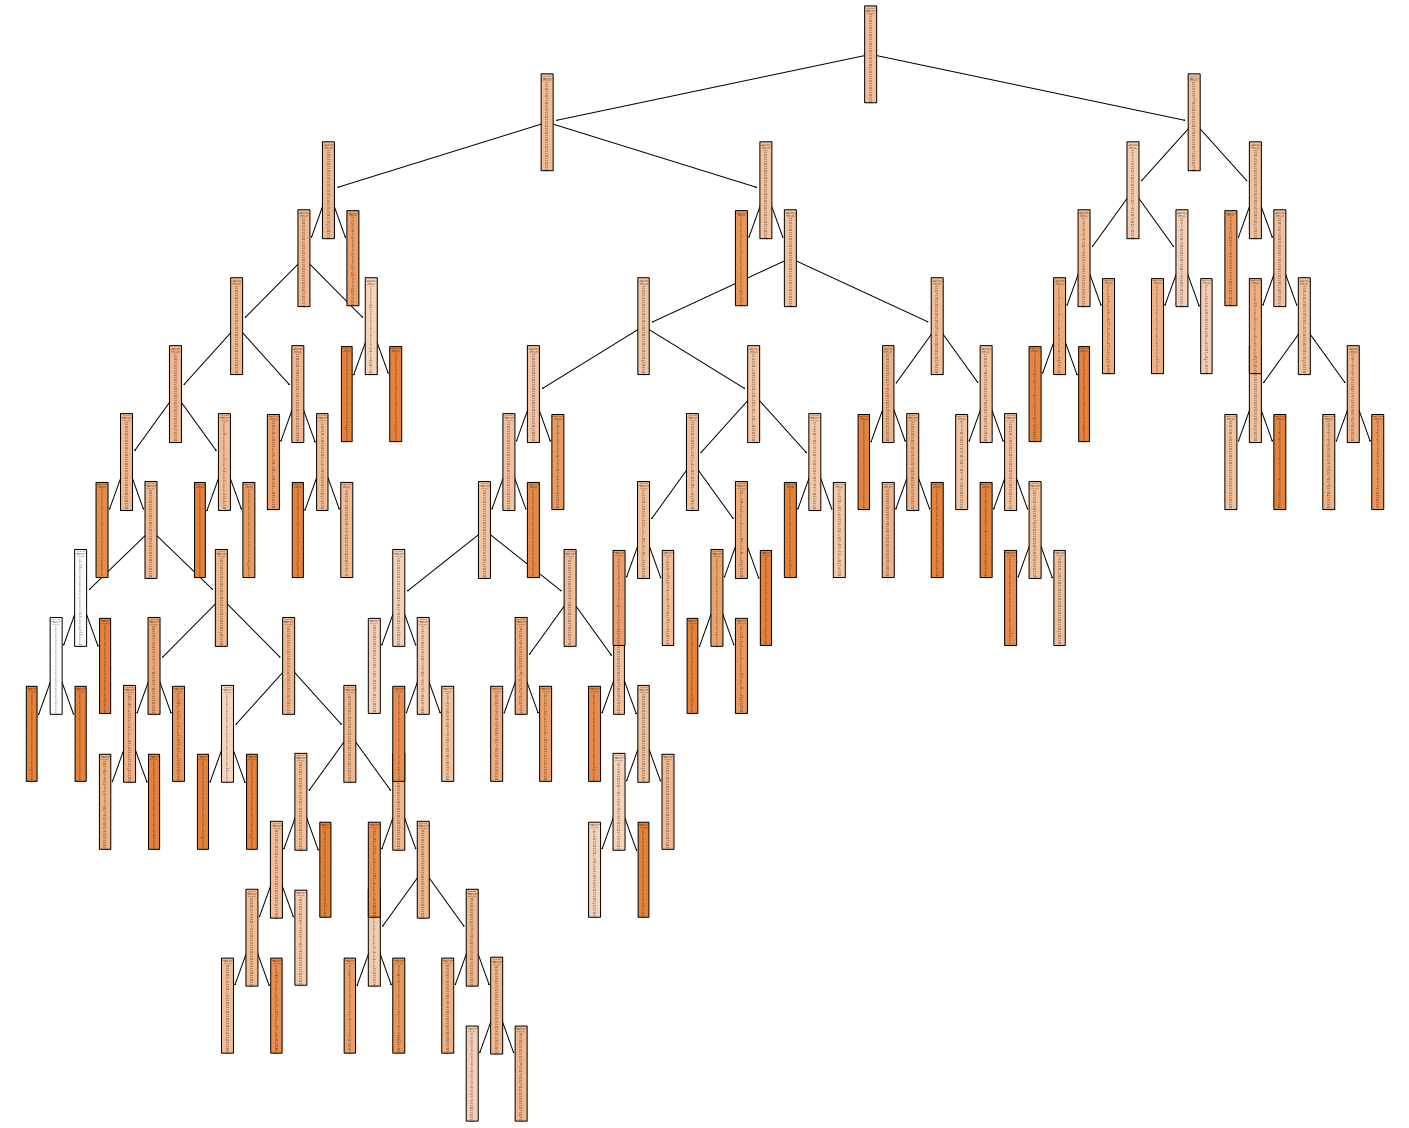

In [41]:
# tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree( trees_fit , filled = True , rounded = True  )

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [42]:
dir(trees_fit)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_X_predict',
 '_validate_data',
 'apply',
 'ccp_alpha',
 'class_weight',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'feature_names_in_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_

Now, we can prune the tree and visualize the prediction rule.

E.g., in the pruned tree the predicted hourly log wage for high-school graduates with more than $9.5$ years of experience is $2.8$, and otherwise is $2.6$.

Finally, we calculate the mean-squared error and the $R^2$ on the test sample to evaluate the out-of-sample performance of the pruned tree.

### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods random forest and boosted trees.

To conclude, let us have a look at our results.

## Results

Above, we displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$
in column 3. We see that the prediction rule produced by Elastic Net using the flexible model performs the best here, giving the lowest test MSE. Cross-Validated Lasso and Ridge, perform nearly as well. For any two of these methods, their testing MSEs are within one standard error of each other. Remarkably, OLS on a simple model performs extremely well, almost as well as best tree based method Random Forest. On the other hand, OLS on a flexible model with many regressors performs very poorly giving the highest test MSE. It is worth to notice that the nonlinear models, e.g. Random Forest, are not tuned. Thus, there is a lot of potential to improve the performance of the nonlinear methods we used in the analysis.

### Ensemble learning

In the final step, we can build a prediction model by combing the strengths of the models we considered so far. This ensemble method is of the form 

\begin{align}
f(x) = \sum_{k=1}^K \alpha_k f_k(x) 
\end{align}

where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights.

We focus on the prediction rules based on OLS, Post-Lasso, Elastic Net, Pruned Tree, Random Forest, Boosted Trees, and Neural Network and combine these methods into an ensemble method. The weights can be determined by a simple ols regression:

Alternatively, we can determine the weights via lasso regression. 

The estimated weights are shown in the following table.

Further, the $R^2$ for the test sample gets improved from $30\%$ obtained by OLS to about $31\%$ obtained by the ensemble method. We see that it is very powerful to aggregate prediction rules into an ensemble rule. Nevertheless, it is worth to notice that we should compare the ensemble method and the single rules on an additional validation set to ensure a fair comparison.

In [43]:
table= np.zeros( (15, 3) )
table[0,0:2]   = MSE_lm_basic
table[1,0:2]   = MSE_lm_flex
table[2,0:2]   = MSE_lasso.iloc[0, [0, 1]]
table[3,0:2]   = MSE_lasso_post.iloc[0, [0, 1]]
table[4,0:2]   = MSE_lasso_flex.iloc[0, [0, 1]]
table[5,0:2]   = MSE_lasso_post_flex.iloc[0, [0, 1]]
table[6,0:2]   = MSE_lasso_cv_basic.iloc[0, [0, 1]]
table[7,0:2]   = MSE_ridge_basic.iloc[0, [0, 1]]
table[8,0:2]   = MSE_elnet_basic.iloc[0, [0, 1]]
table[9,0:2]   = MSE_lasso_cv_flex.iloc[0, [0, 1]]
table[10,0:2]  = MSE_ridge_flex.iloc[0, [0, 1]]
table[11,0:2]  = MSE_elnet_flex.iloc[0, [0, 1]]
# table[13,1:2]  = MSE_rf
# table[14,1:2]  = MSE_boost
# table[15,1:2]  = MSE_pt



table[0,2]   = R2_lm_basic
table[1,2]   = R2_lm_flex
table[2,2]   = R2_lasso
table[3,2]   = R2_lasso_post
table[4,2]   = R2_lasso_flex
table[5,2]   = R2_lasso_post_flex
table[6,2]   = R2_lasso_cv_basic
table[7,2]   = R2_ridge_basic
table[8,2]   = R2_elnet_basic
table[9,2]   = R2_lasso_cv_flex
table[10,2]  = R2_ridge_flex
table[11,2]  = R2_elnet_flex
# table[13,3]  = R2_rf
# table[14,3]  = R2_boost
# table[15,3]  = R2_pt




colnames_table= ["MSE", "S_E_ for MSE", "R-squared"]
rownames_table= ["Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", \
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  \
                    "Random Forest","Boosted Trees", "Pruned Tree"]
table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round(3)
table_html = table_pandas.to_latex()
table_pandas

,MSE,S_E_ for MSE,R-squared
Least Squares (basic),0.245,0.016,0.262
Least Squares (flexible),0.275,0.022,0.172
Lasso,0.250,0.016,0.246
Post-Lasso,0.250,0.017,0.246
Lasso (flexible),0.251,0.016,0.246
Post-Lasso (flexible),0.253,0.017,0.237
Cross-Validated lasso,0.245,0.016,0.005
Cross-Validated ridge,0.330,0.018,0.261
Cross-Validated elnet,0.244,0.017,0.264
Cross-Validated lasso (flexible),0.246,0.017,0.011
